Unit 2- Lesson 5- Project 2

## Challenge: Validating a linear regression

Validating regression models for prediction
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.



## Import Data and clean

In [1]:
# Import necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


%matplotlib inline
sns.set_style('white')

In [2]:
#read in the excel file
df = pd.read_excel ('table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls')

In [3]:
#The top few rows of the data fram are blank, drop the blank rows and locate the column titles
#Then reset the index
df_nypd = df.drop([0,1,2, 3])
df_nypd.columns = df.iloc[3]
df_nypd= df_nypd.reset_index(drop=True)

In [4]:
#Clean up the column titles for quick acces and itteration
df_nypd.columns = df_nypd.columns.str.strip().str.lower().str.replace(' ','_').str.replace('(', '').str.replace(')','').str.replace('\n', '_')


In [5]:
#Replace missing values with 0's or mean from column
df_nypd.loc[df_nypd['murder_and_nonnegligent_manslaughter'].isna(), 'murder_and_nonnegligent_manslaughter'] =0
df_nypd.loc[df_nypd['robbery'].isna(), 'robbery'] =0
df_nypd['population'] = df_nypd.population.fillna(df_nypd.population.mean())
df_nypd['property_crime'] = df_nypd.property_crime.fillna(df_nypd.property_crime.mean())

In [6]:
#last three rows are blank/null remove them from data set
df_nypd = df_nypd[:-3] 

In [7]:
#read in second data set from 2014
df2 = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls')

In [8]:
#repeat the process- locate column title rows and drop blanks, then reset index
df_14 = df2.drop([0,1,2,3])
df_14.columns = df2.iloc[3]
df_14 = df_14.reset_index(drop=True)

In [9]:
#drop blank rows from the end of the data set
df_14 = df_14[:-7]

In [10]:
#clean the column titles for quick iterations
df_14.columns = df_14.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('\n', '_')

In [47]:
#removed New York from data set as an outlier (even though it is where I live and I would like to be inclusive, it deserves its own model)
df_nypd= df_nypd.loc[df_nypd['city'] != 'New York']



In [48]:
df_nypd.head(20)

3,city,population,violent_crime,murder_and_nonnegligent_manslaughter,rape_revised_definition1,rape_legacy_definition2,robbery,aggravated_assault,property_crime,burglary,larceny-_theft,motor_vehicle_theft,arson3
0,Adams Village,1861.0,0,0,NaN,0,0,0,12.0,2,10,0,0
1,Addison Town and Village,2577.0,3,0,NaN,0,0,3,24.0,3,20,1,0
2,Akron Village,2846.0,3,0,NaN,0,0,3,16.0,1,15,0,0
3,Albany,97956.0,791,8,NaN,30,227,526,4090.0,705,3243,142,NaN
4,Albion Village,6388.0,23,0,NaN,3,4,16,223.0,53,165,5,NaN
5,Alfred Village,4089.0,5,0,NaN,0,3,2,46.0,10,36,0,NaN
6,Allegany Village,1781.0,3,0,NaN,0,0,3,10.0,0,10,0,0
7,Amherst Town,118296.0,107,1,NaN,7,31,68,2118.0,204,1882,32,3
8,Amityville Village,9519.0,9,0,NaN,2,4,3,210.0,16,188,6,1
9,Amsterdam,18182.0,30,0,NaN,0,12,18,405.0,99,291,15,0


In [49]:
df_nypd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347 entries, 0 to 347
Data columns (total 13 columns):
city                                    347 non-null object
population                              347 non-null float64
violent_crime                           347 non-null object
murder_and_nonnegligent_manslaughter    347 non-null object
rape_revised_definition1                0 non-null object
rape_legacy_definition2                 347 non-null object
robbery                                 347 non-null object
aggravated_assault                      347 non-null object
property_crime                          347 non-null float64
burglary                                347 non-null object
larceny-_theft                          347 non-null object
motor_vehicle_theft                     347 non-null object
arson3                                  187 non-null object
dtypes: float64(2), object(11)
memory usage: 38.0+ KB


## Select Features

In [110]:
features = pd.DataFrame(df_nypd['population'])

In [111]:
#features['population_sqd'] = df_nypd['population']*df_nypd['population']

In [112]:
#change murder and robbery to categorical features
features['violent_crime'] = np.where(df_nypd['violent_crime']> 0, 1, 0)
features['robbery']= np.where(df_nypd['robbery']>0, 1,0)
#features['assault']=np.where(df_nypd['aggravated_assault']>0,1,0)

In [113]:
features.head(20)

,population,violent_crime,robbery
0,1861.0,0,0
1,2577.0,1,0
2,2846.0,1,0
3,97956.0,1,1
4,6388.0,1,1
5,4089.0,1,1
6,1781.0,1,0
7,118296.0,1,1
8,9519.0,1,1
9,18182.0,1,1


In [114]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347 entries, 0 to 347
Data columns (total 3 columns):
population       347 non-null float64
violent_crime    347 non-null int64
robbery          347 non-null int64
dtypes: float64(1), int64(2)
memory usage: 10.8 KB


In [115]:
target = np.where(df_nypd['murder_and_nonnegligent_manslaughter']>0,1,0)

In [116]:
target

array([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,

In [117]:
X = features
y = target

In [118]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [119]:
# Create a Linear regression and fit it to the training set
regr = LinearRegression()

regr.fit(X_train,y_train)

# Predict on the test data: y_pred
y_pred = regr.predict(X_test)

# Compute and print R^2 
print("R^2: {}".format(regr.score(X_test, y_test)))
print(regr.score(X_train, y_train))

R^2: 0.2919541828622073
0.2632280256478502


In [120]:
cv_results= cross_val_score(regr, X, y, cv=3)
print(cv_results)
print(np.mean(cv_results))

[0.12656389 0.19703314 0.27632312]
0.19997338240717158


In [121]:
cv_results= cross_val_score(regr, X, y, cv=5)
print(cv_results)
print(np.mean(cv_results))

[ 0.24790726 -0.03743031  0.25303272  0.27626224  0.29904558]
0.20776349820454493


In [122]:
cv_results= cross_val_score(regr, X, y, cv=10)
print(cv_results)
print(np.mean(cv_results))

[ 0.43490944 -1.59710032 -0.017451   -0.02377842  0.2336988   0.24711263
  0.04159663  0.33188747  0.25559079  0.3635159 ]
0.02699819205513615


               population  violent_crime   robbery
population       1.000000       0.200591  0.344347
violent_crime    0.200591       1.000000  0.507766
robbery          0.344347       0.507766  1.000000


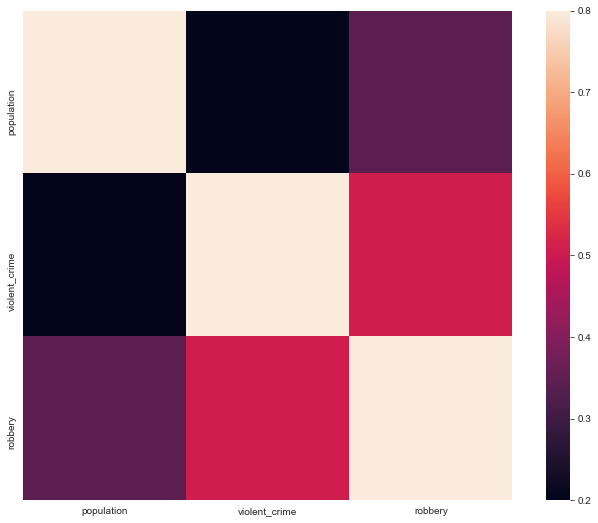

In [123]:
# Make the correlation matrix.
corrmat = features.corr()
print(corrmat)

# Set up the figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()


In [124]:
data = pd.DataFrame(features)

In [125]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 347 entries, 0 to 347
Data columns (total 3 columns):
population       347 non-null float64
violent_crime    347 non-null int64
robbery          347 non-null int64
dtypes: float64(1), int64(2)
memory usage: 10.8 KB


In [129]:
# Instantiate and fit our model.
reg = LinearRegression()
Yy = y.reshape(-1, 1)
Xx = data[['population','robbery','violent_crime']]
reg.fit(Xx, Yy)

# Inspect the results.
print('\nCoefficients: \n', reg.coef_)
print('\nIntercept: \n', reg.intercept_)
print('\nR-squared:')
print(reg.score(Xx, Yy))


Coefficients: 
 [[ 5.73447352e-06  1.11201986e-01 -3.82726255e-03]]

Intercept: 
 [-0.01656701]

R-squared:
0.2741482606673049


In [130]:
cv_results= cross_val_score(reg, Xx, Yy, cv=3)
print(cv_results)
print(np.mean(cv_results))

[0.12656389 0.19703314 0.27632312]
0.19997338240717158


In [131]:
data= pd.DataFrame(features)

In [132]:
data['property_crime']= np.where(df_nypd['property_crime'] > 0, 1,0)

In [133]:
linear_formula = 'property_crime ~ population+robbery+murder+assault'

# Fit the model to our data using the formula.
lm = smf.ols(formula=linear_formula, data=data).fit()

PatsyError: Error evaluating factor: NameError: name 'assault' is not defined
    property_crime ~ population+robbery+murder+assault
                                               ^^^^^^^

In [134]:
lm.params

Intercept               2.833331
robbery[T.1]           33.358263
robbery[T.2]           97.395205
robbery[T.3]           86.545855
robbery[T.4]          119.671849
robbery[T.5]          171.465105
robbery[T.6]          107.479231
robbery[T.7]          120.823985
robbery[T.8]           57.070481
robbery[T.9]           93.162343
robbery[T.10]         339.025051
robbery[T.11]          56.533761
robbery[T.12]         280.729436
robbery[T.13]         103.492988
robbery[T.15]         933.899234
robbery[T.16]         450.622283
robbery[T.17]         283.128816
robbery[T.19]         400.390669
robbery[T.20]         425.107381
robbery[T.21]         -28.752733
robbery[T.22]         335.449725
robbery[T.23]         141.579764
robbery[T.24]        -152.272797
robbery[T.25]         262.428661
robbery[T.26]         262.596467
robbery[T.28]         412.901427
robbery[T.29]         407.960193
robbery[T.31]        1205.131721
robbery[T.34]         140.209403
robbery[T.39]         458.206541
          

In [135]:
round(lm.pvalues, 7)

Intercept           8.049025e-01
robbery[T.1]        2.694990e-02
robbery[T.2]        1.470000e-05
robbery[T.3]        2.506000e-04
robbery[T.4]        1.292000e-04
robbery[T.5]        1.000000e-06
robbery[T.6]        1.180130e-02
robbery[T.7]        3.477260e-02
robbery[T.8]        3.490967e-01
robbery[T.9]        2.147422e-01
robbery[T.10]       4.000000e-07
robbery[T.11]       2.679281e-01
robbery[T.12]       1.745000e-04
robbery[T.13]       1.301439e-01
robbery[T.15]       0.000000e+00
robbery[T.16]       0.000000e+00
robbery[T.17]       1.416290e-02
robbery[T.19]       0.000000e+00
robbery[T.20]       0.000000e+00
robbery[T.21]       7.954523e-01
robbery[T.22]       0.000000e+00
robbery[T.23]       7.200000e-06
robbery[T.24]       3.764382e-01
robbery[T.25]       1.000000e-07
robbery[T.26]       5.200000e-06
robbery[T.28]       0.000000e+00
robbery[T.29]       0.000000e+00
robbery[T.31]       0.000000e+00
robbery[T.34]       3.078320e-02
robbery[T.39]       0.000000e+00
          

In [136]:
lm.rsquared

0.9999006431735566

In [137]:
round(lm.conf_int(),7)

,0,1
Intercept,-19.732084,25.398745
robbery[T.1],3.834595,62.881931
robbery[T.2],53.989211,140.801199
robbery[T.3],40.654789,132.436921
robbery[T.4],59.047390,180.296308
robbery[T.5],104.232354,238.697856
robbery[T.6],24.025344,190.933118
robbery[T.7],8.712040,232.935930
robbery[T.8],-62.737590,176.878551
robbery[T.9],-54.349100,240.673787
